# Inference with Segment-NT models

## Installation and imports

In [1]:
!pip install biopython

In [2]:
from Bio import SeqIO
import gzip
import numpy as np
import transformers
from transformers import AutoTokenizer, AutoModel
import torch
import seaborn as sns
from typing import List
import matplotlib.pyplot as plt

## Download the model
The following cell allows you to download the config and the model of one of the Segment-NT models.

In [3]:
# Load model directly
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("InstaDeepAI/segment_nt", trust_remote_code=True)
model = AutoModel.from_pretrained("InstaDeepAI/segment_nt", trust_remote_code=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


# Define function that plots the probabilities

In [4]:
# seaborn settings
sns.set_style("whitegrid")
sns.set_context(
    "notebook",
    font_scale=1,
    rc={
        "font.size": 14,
        "axes.titlesize": 18,
        "axes.labelsize": 18,
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        "legend.fontsize": 16,
        }
)

plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

# set colors
colors = sns.color_palette("Set2").as_hex()
colors2 = sns.color_palette("husl").as_hex()


# Rearrange order of the features to match Fig.3 from the paper
features_rearranged = [
 'protein_coding_gene',
 'lncRNA',
 '5UTR',
 '3UTR',
 'exon',
 'intron',
 'splice_donor',
 'splice_acceptor',
 'promoter_Tissue_specific',
 'promoter_Tissue_invariant',
 'enhancer_Tissue_specific',
 'enhancer_Tissue_invariant',
 'CTCF-bound',
 'polyA_signal',
]

def plot_features(
    predicted_probabilities_all,
    seq_length: int,
    features: List[str],
    order_to_plot: List[str],
    fig_width=8,
):
    """
    Function to plot labels and predicted probabilities.

    Args:
        predicted_probabilities_all: Probabilities per genomic feature for each
            nucleotides in the DNA sequence.
        seq_length: DNA sequence length.
        feature: Genomic features to plot.
        order_to_plot: Order in which to plot the genomic features. This needs to be
            specified in order to match the order presented in the Fig.3 of the paper
        fig_width: Width of the figure
    """

    sc = 1.8
    n_panels = 7

    # fig, axes = plt.subplots(n_panels, 1, figsize=(fig_width * sc, (n_panels + 2) * sc), height_ratios=[6] + [2] * (n_panels-1))
    _, axes = plt.subplots(n_panels, 1, figsize=(fig_width * sc, (n_panels + 4) * sc))

    for n, feat in enumerate(order_to_plot):
        feat_id = features.index(feat)
        prob_dist = predicted_probabilities_all[:, feat_id]

        # Use the appropriate subplot
        ax = axes[n // 2]

        try:
            id_color = colors[feat_id]
        except:
            id_color = colors2[feat_id - 8]
        ax.plot(
            prob_dist,
            color=id_color,
            label=feat,
            linestyle="-",
            linewidth=1.5,
        )
        ax.set_xlim(0, seq_length)
        ax.grid(False)
        ax.spines['bottom'].set_color('black')
        ax.spines['top'].set_color('black')
        ax.spines['right'].set_color('black')
        ax.spines['left'].set_color('black')

    for a in range (0,n_panels):
        axes[a].set_ylim(0, 1.05)
        axes[a].set_ylabel("Prob.")
        axes[a].legend(loc="upper left", bbox_to_anchor=(1, 1), borderaxespad=0)
        if a != (n_panels-1):
            axes[a].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)

    # Set common x-axis label
    axes[-1].set_xlabel("Nucleotides")
    # axes[0].axis('off')  # Turn off the axis
    axes[n_panels-1].grid(False)
    axes[n_panels-1].tick_params(axis='y', which='both', left=True, right=False, labelleft=True, labelright=False)

    axes[0].set_title("Probabilities predicted over all genomics features", fontweight="bold")

    plt.show()


# Get human chromosome 20

To reproduce the figures of the Segment-NT paper, we retrieve here the file of the
human chromosome 20

In [5]:
! wget https://ftp.ensembl.org/pub/release-111/fasta/homo_sapiens/dna/Homo_sapiens.GRCh38.dna.chromosome.20.fa.gz

--2024-03-29 09:35:54--  https://ftp.ensembl.org/pub/release-111/fasta/homo_sapiens/dna/Homo_sapiens.GRCh38.dna.chromosome.20.fa.gz
Resolving ftp.ensembl.org (ftp.ensembl.org)... 193.62.193.169
Connecting to ftp.ensembl.org (ftp.ensembl.org)|193.62.193.169|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18833053 (18M) [application/x-gzip]
Saving to: ‘Homo_sapiens.GRCh38.dna.chromosome.20.fa.gz.2’

Homo_sapiens.GRCh38 100%[===================>]  17.96M   661KB/s    in 28s     

2024-03-29 09:36:23 (655 KB/s) - ‘Homo_sapiens.GRCh38.dna.chromosome.20.fa.gz.2’ saved [18833053/18833053]



In [6]:
fasta_path = "Homo_sapiens.GRCh38.dna.chromosome.20.fa.gz"

with gzip.open(fasta_path, "rt") as handle:
    record = next(SeqIO.parse(handle, "fasta"))
    chr20 = str(record.seq)

# Infer on 10kb genomic sequence (Does not require changing the rescaling factor in the forward function)

## Instantiate SegmentNT inference function
The following cell allows you to download the weights of one of the Segment-NT models. It returns the weights dictionary, the haiku forward function, the tokenizer and the config dictionary.

Just like for the `get_pretrained_nucleotide_transformer` function, you can also specify:
1. the layers at which you'd like to collect embeddings (e.g. (5, 10, 20) to get embeddings at layers 5, 10 and 20)
2. the attention maps you´d like to collect (e.g. ((1,4), (7,18)) to get attention maps corresponding to layer 1 head number 4 and layer 7 head number 18). Please refer to the config to see the number of layers and heads in the model.
3. the maximum number of tokens in the sequences you'll compute the inference on. You can put values up to value specified in the model's config (counting the class token that will be added automatically at the beginning of the sequence), however we recommend keeping this number as small as possible for optimized memory and inference time.

In [7]:
# The number of DNA tokens (excluding the CLS token prepended) needs to be dividible by
# the square of the number of downsampling block in SegmentNT UNet head, i.e 4.
# In the paper and in the jax colab, the length is set at 8333 tokens, which corresponds
# to 49992 nucleotides. On Google Colab, the inference with this length fits on the
# JAX model but does not fit in the Torch model. Therefore, we select here a slightly
# smaller length.
max_num_dna_tokens = 1668

# If max_num_tokens is larger than what was used to train Segment-NT, the rescaling
# factor needs to be adapted.
if max_num_dna_tokens + 1 > 5001:
    inference_rescaling_factor = (max_num_dna_tokens + 1) / 2048

    # Apply the new rescaling factor to all Rotary Embeddings layer.
    num_layers = len(model.esm.encoder.layer)

    for layer in range(num_layers):
      model.esm.encoder.layer[layer].attention.self.rotary_embeddings.rescaling_factor = inference_rescaling_factor
else:
    inference_rescaling_factor = None



## Tokenize the DNA sequence

In [8]:
idx_start = 2650520
idx_stop = idx_start + max_num_dna_tokens*6

sequences = [chr20[idx_start:idx_stop]]
tokens = tokenizer.batch_encode_plus(sequences, return_tensors="pt", padding="max_length", max_length = max_num_dna_tokens)["input_ids"]


## Infer on the resulting batch

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.cuda()
# Infer
tokens = tokens.cuda()
attention_mask = (tokens != tokenizer.pad_token_id).cuda()
with torch.no_grad():
  outs = model(
      tokens,
      attention_mask=attention_mask,
  )

In [10]:
# Obtain the logits over the genomic features
logits = outs["logits"]
# Transform them on probabilities
probabilities = np.asarray(torch.nn.functional.softmax(logits, dim=-1).cpu())[...,-1]

In [11]:
del outs

In [12]:
del tokens, attention_mask

## Plot the probabilities for 14 genomic features along this DNA sequence

Please note that Fig.1 from the SegmentNT paper is realized with SegmentNT-10kb, whereas here SegmentNT-30kb is used, which explains why the probabilities are not the exact same.

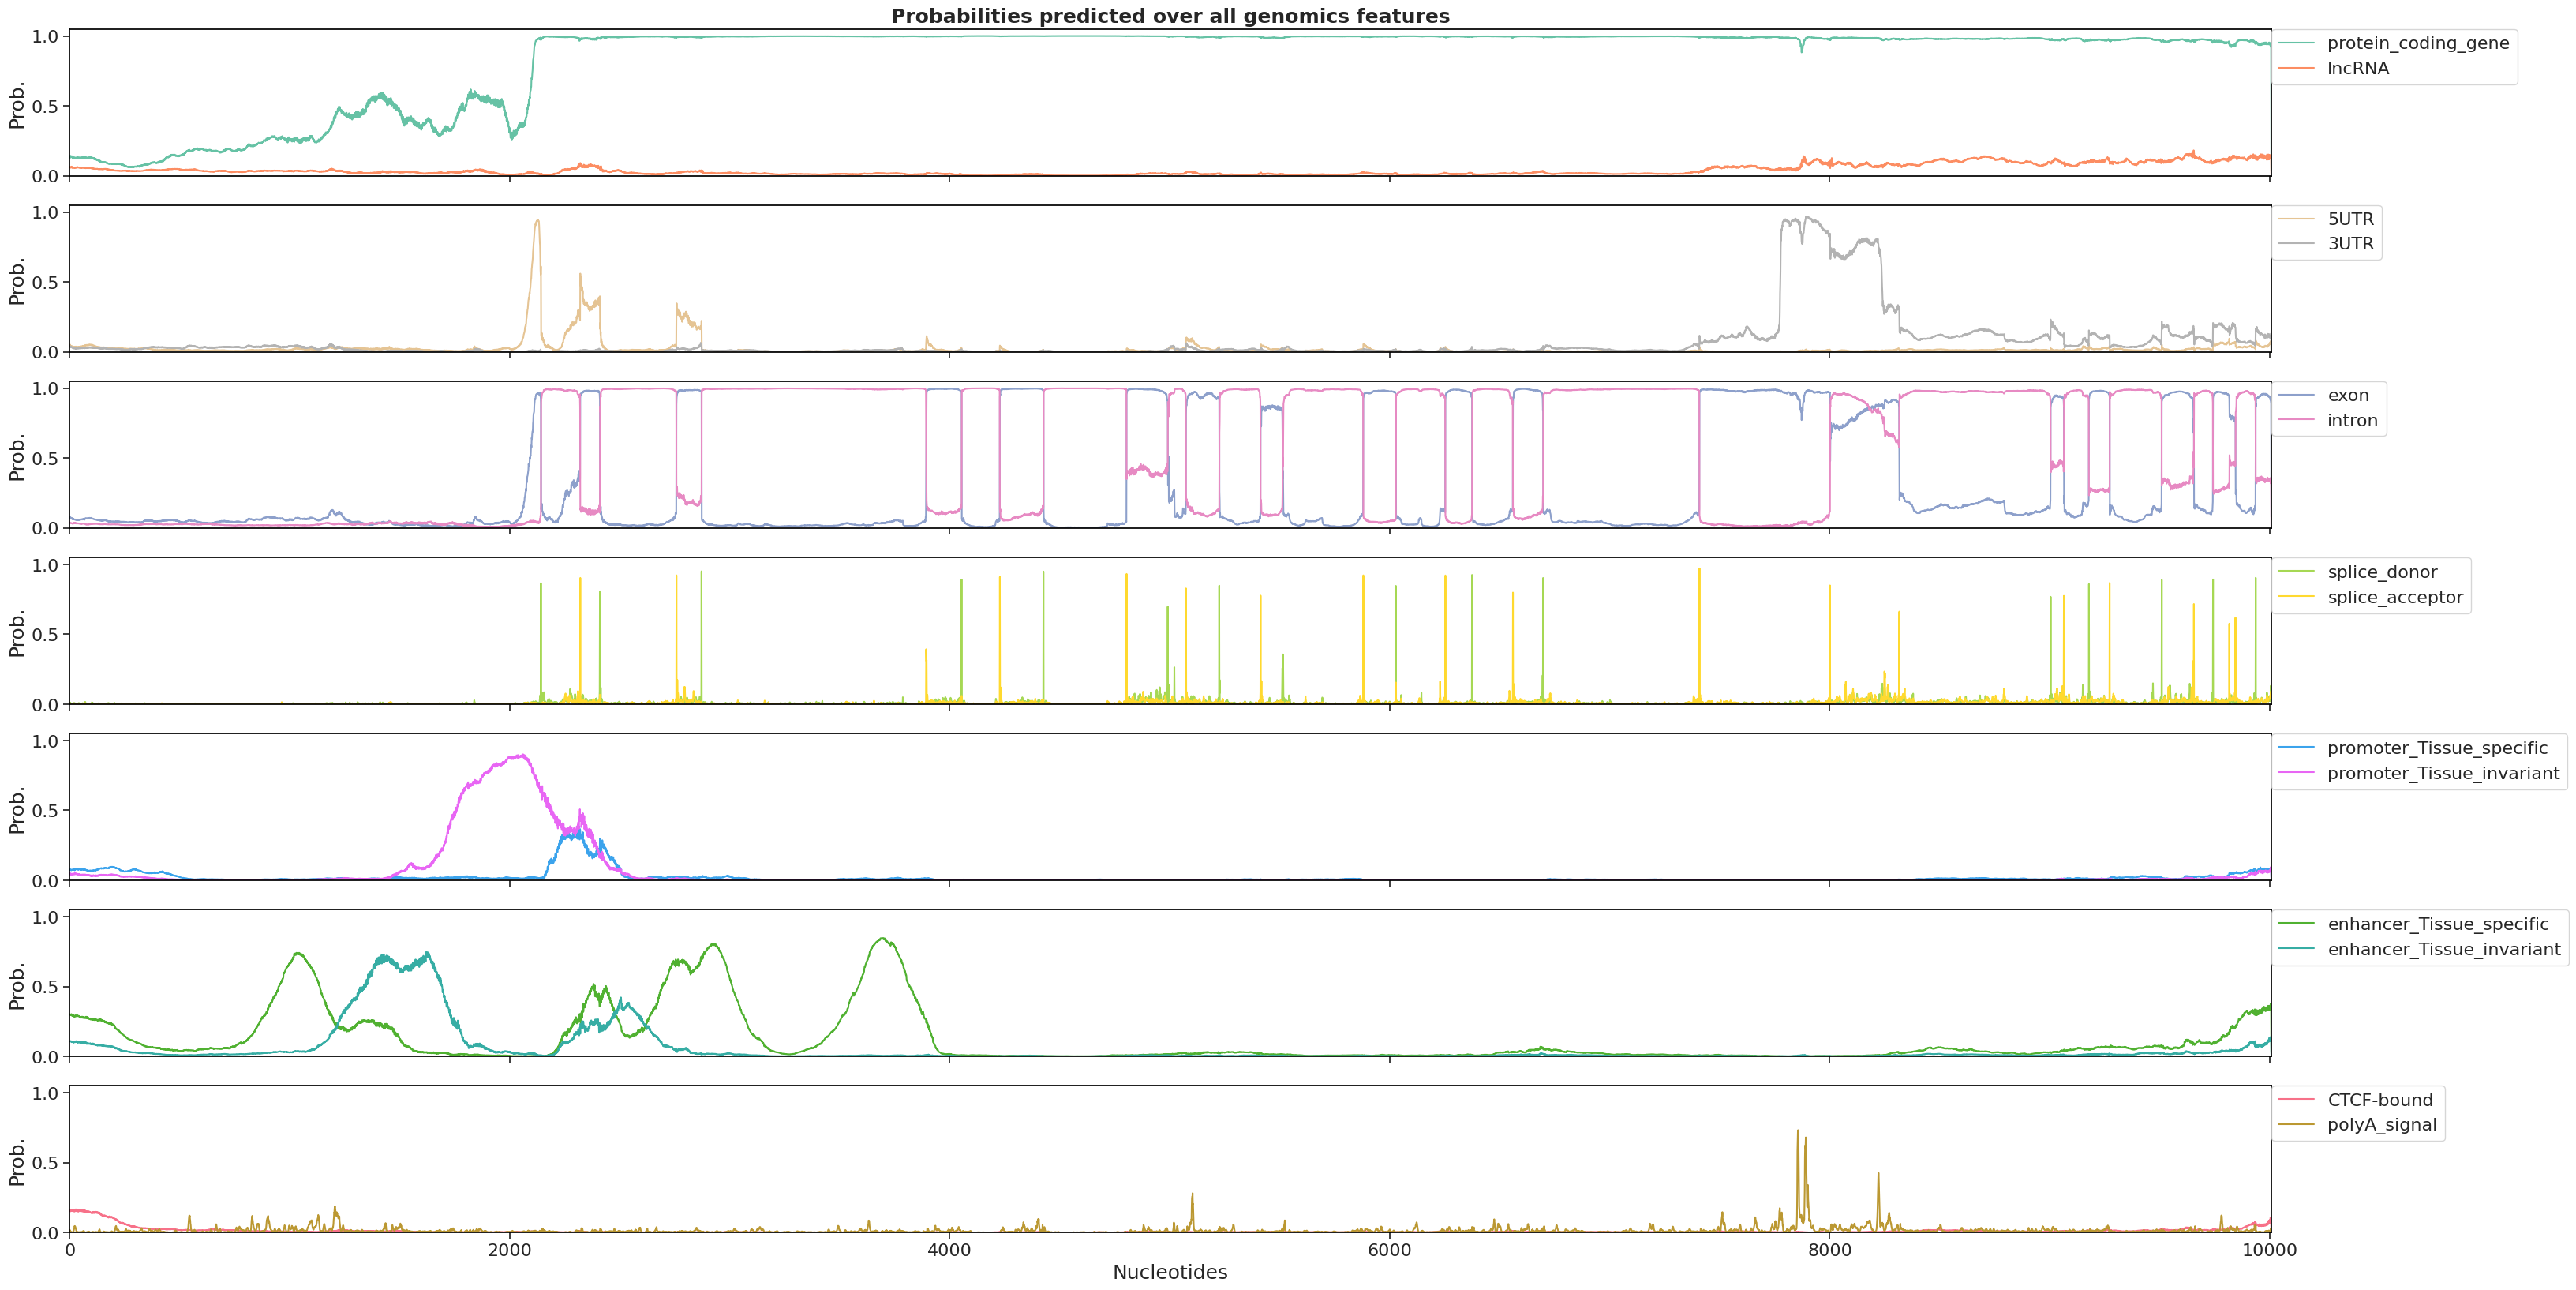

In [13]:
plot_features(
    probabilities[0],
    probabilities.shape[-2],
    fig_width=20,
    features=model.config.features,
    order_to_plot=features_rearranged
)

# Infer and plot on 50kb genomic sequence (Requires changing the rescaling factor in the forward function)

## Instantiate SegmentNT inference function

In [14]:
# The number of DNA tokens (excluding the CLS token prepended) needs to be dividible by
# the square of the number of downsampling block in SegmentNT UNet head, i.e 4.
# In the paper and in the jax colab, the length is set at 8333 tokens, which corresponds
# to 49992 nucleotides. On Google Colab, the inference with this length fits on the
# JAX model but does not fit in the Torch model. Therefore, we select here a slightly
# smaller length.
max_num_dna_tokens = 8200

# If max_num_tokens is larger than what was used to train Segment-NT, the rescaling
# factor needs to be adapted.
if max_num_dna_tokens + 1 > 5001:
    inference_rescaling_factor = (max_num_dna_tokens + 1) / 2048

    # Apply the new rescaling factor to all Rotary Embeddings layer.
    num_layers = len(model.esm.encoder.layer)

    for layer in range(num_layers):
      model.esm.encoder.layer[layer].attention.self.rotary_embeddings.rescaling_factor = inference_rescaling_factor
else:
    inference_rescaling_factor = None

## Tokenize the DNA sequence

In [15]:
idx_start = 5099984
idx_stop = idx_start + max_num_dna_tokens*6

sequences = [chr20[idx_start:idx_stop]]
tokens = tokenizer.batch_encode_plus(sequences, return_tensors="pt", padding="max_length", max_length = max_num_dna_tokens)["input_ids"]


## Infer on the resulting batch

In [16]:
import gc

gc.collect()
torch.cuda.empty_cache()

In [17]:
# Infer
tokens = tokens.cuda()
attention_mask = (tokens != tokenizer.pad_token_id).cuda()
with torch.no_grad():
  outs = model(
      tokens,
      attention_mask=attention_mask,
  )

In [18]:
# Obtain the logits over the genomic features
logits = outs["logits"]
# Transform them on probabilities
probabilities = np.asarray(torch.nn.functional.softmax(logits, dim=-1).cpu())[...,-1]

## Plot the probabilities for 14 genomic features along this DNA sequence

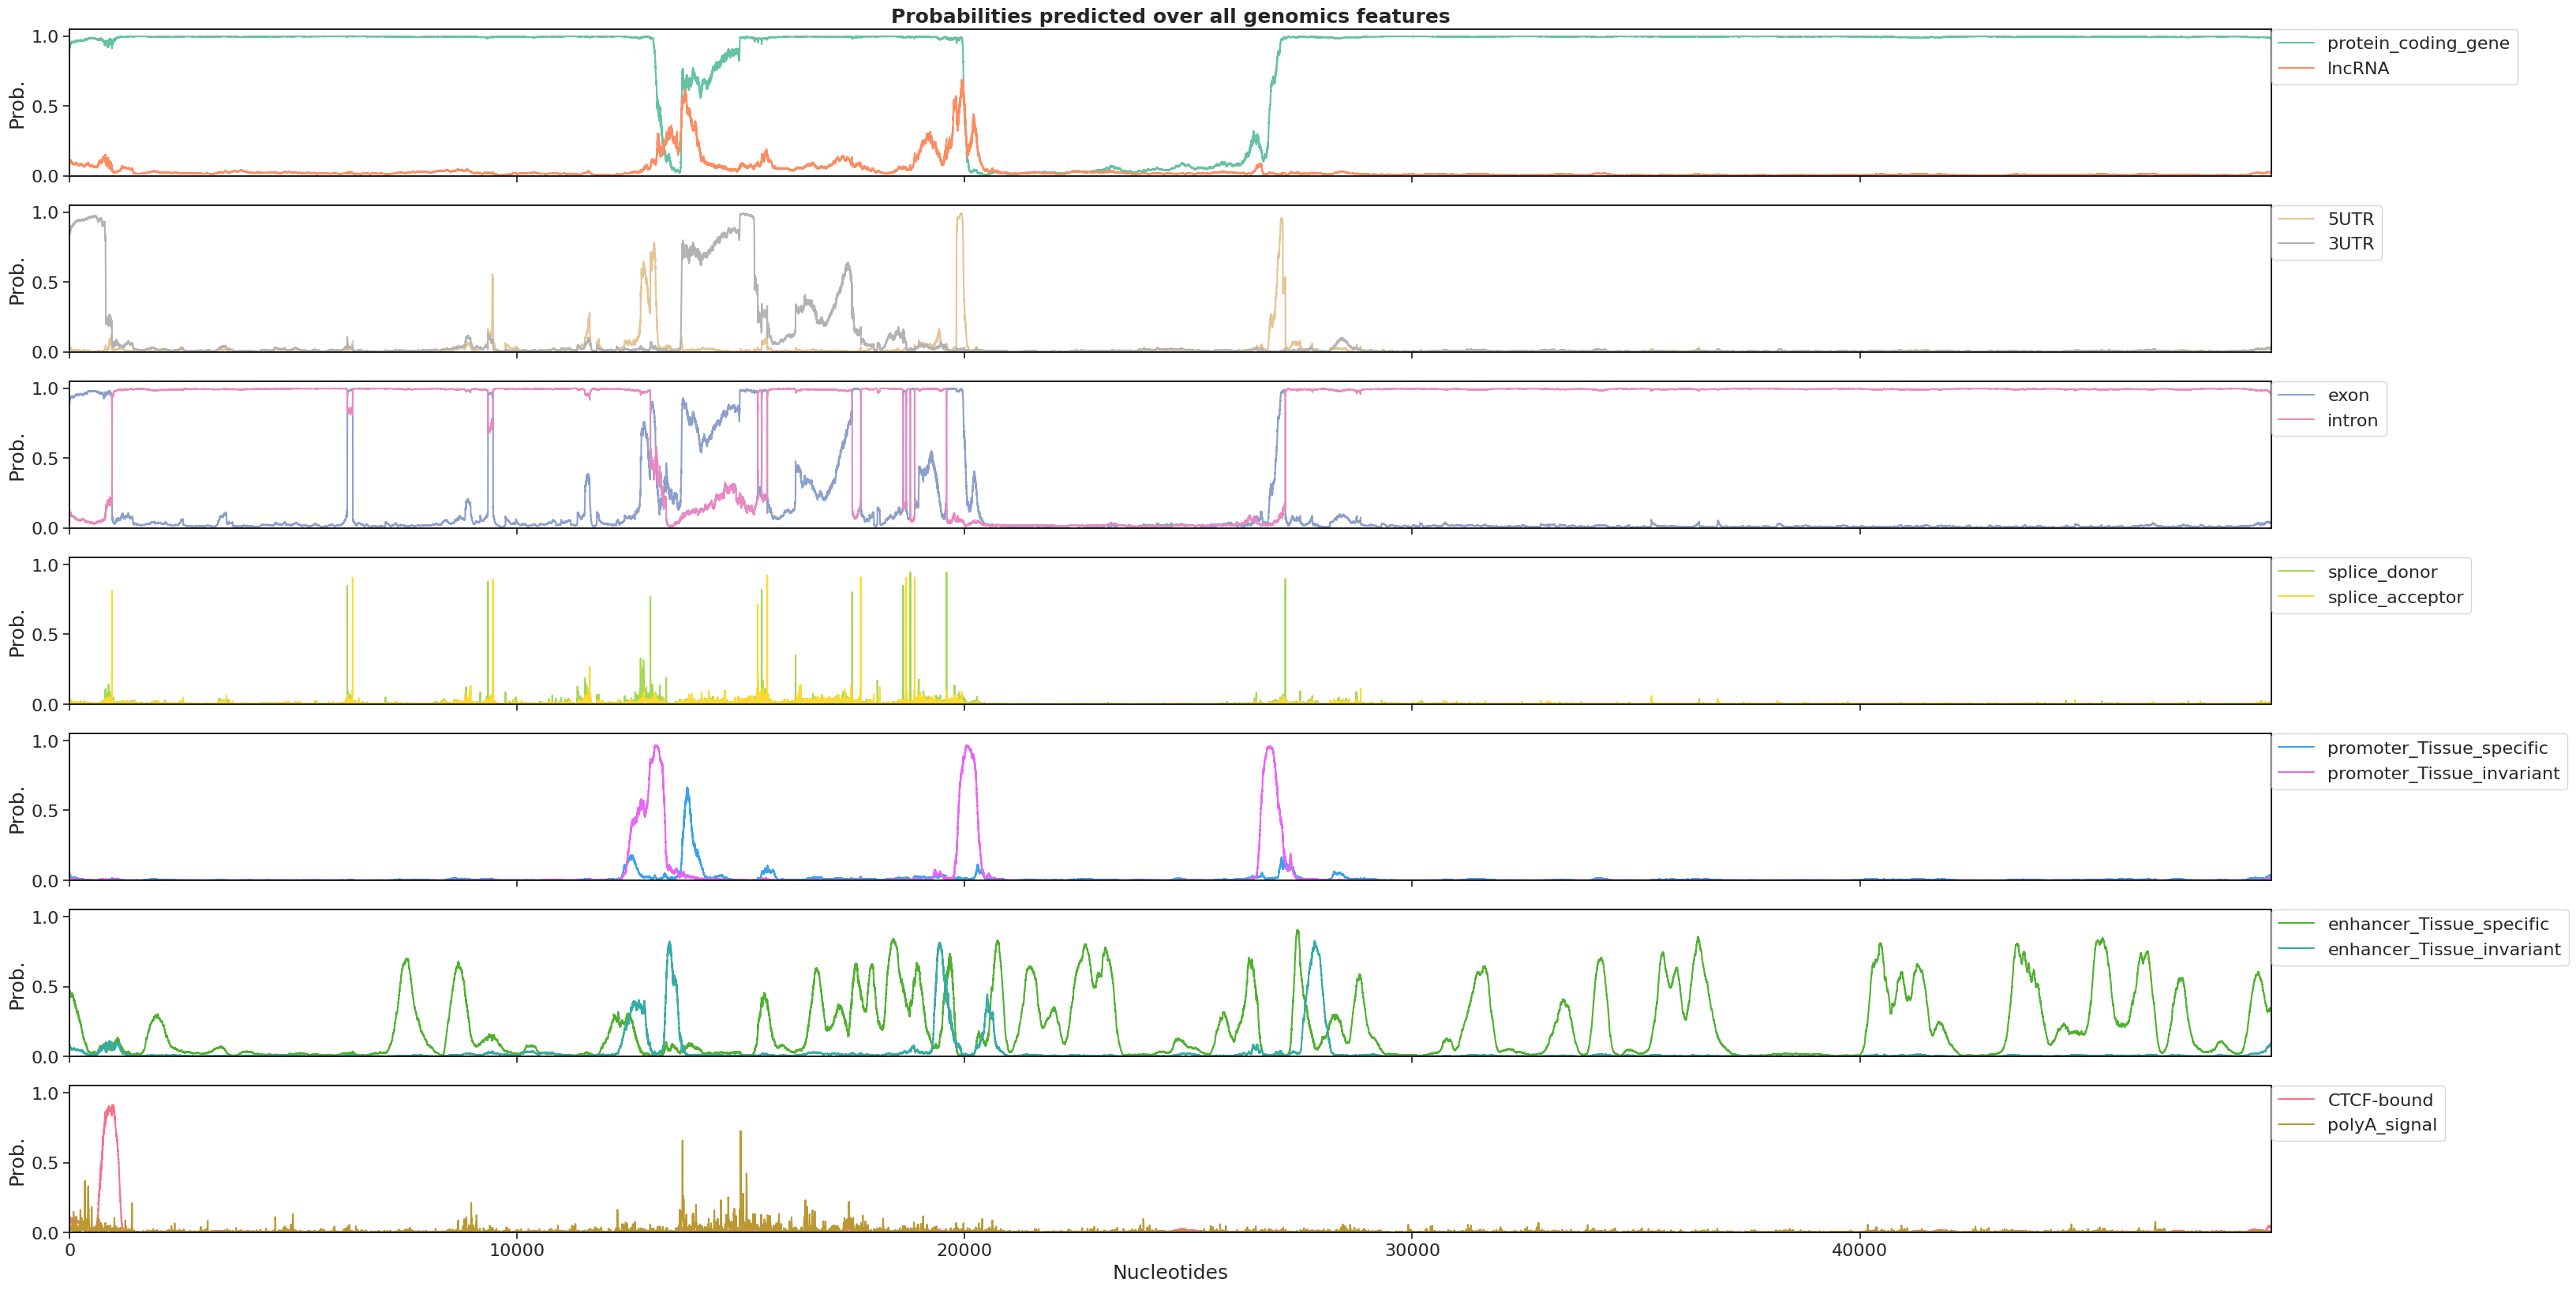

In [19]:
plot_features(
    probabilities[0],
    probabilities.shape[-2],
    fig_width=20,
    features=model.config.features,
    order_to_plot=features_rearranged
)